# Working example of space + lateral erosion + landslides
<hr>



In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import copy
import matplotlib as mpl

from landlab import imshow_grid,imshowhs_grid, RasterModelGrid
from landlab.components import (
    FlowAccumulator,
    DepressionFinderAndRouter,
    SpaceLargeScaleEroder,
    PriorityFloodFlowRouter,
    LateralEroderSolo, 
    FastscapeEroder,
    BedrockLandslider
)

Below is a fancy plotting function from BC's bedrocklandslides_on_DEMs notebook

In [2]:
def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        cmap = copy.copy(mpl.cm.get_cmap("terrain"))
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap=cmap,
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = copy.copy(mpl.cm.get_cmap("terrain"))
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

Create raster grid with space

In [3]:
# nr = 20
# nc = 20
nr = 75
nc = 75
xy_spacing = 10.0
mg = RasterModelGrid((nr, nc), xy_spacing=xy_spacing)
z = mg.add_zeros("topographic__elevation", at="node")
mg.at_node["topographic__elevation"][mg.core_nodes] += np.random.rand(
    mg.number_of_core_nodes
)

s = mg.add_zeros("soil__depth", at="node", dtype=float)
mg.at_node["soil__depth"][mg.core_nodes] += 0.5
mg.at_node["topographic__elevation"] += mg.at_node["soil__depth"]

fr = PriorityFloodFlowRouter(mg, flow_metric="D8", update_flow_depressions=True)
# fr = PriorityFloodFlowRouter(
#     mg,
#     surface="topographic__elevation",
#     flow_metric="D8",
#     suppress_out=True,
#     depression_handler="fill",
#     accumulate_flow=True,
#     separate_hill_flow=True,
#     accumulate_flow_hill=True,
# )
ha = SpaceLargeScaleEroder(mg, K_sed=0.00005, K_br=0.00005, phi=0.3, H_star=1)

br = mg.at_node["bedrock__elevation"]
z = mg.at_node["topographic__elevation"]

space_dt = 500

In [10]:
z_ori = np.array(z)
t1 = time.time()
for i in tqdm(range(500)):
    # Uplift
    br[mg.core_nodes] += 0.001 * space_dt

    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)
z_endspace = mg.at_node["topographic__elevation"].copy()
s_endspace = mg.at_node["soil__depth"].copy()
br_endspace = mg.at_node["bedrock__elevation"].copy()

t_span1 = time.time() - t1
print('Total run time is %.f s' %t_span1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:48<00:00, 10.30it/s]

Total run time is 49 s


Text(0.5, 1.0, 'Soil Depth')

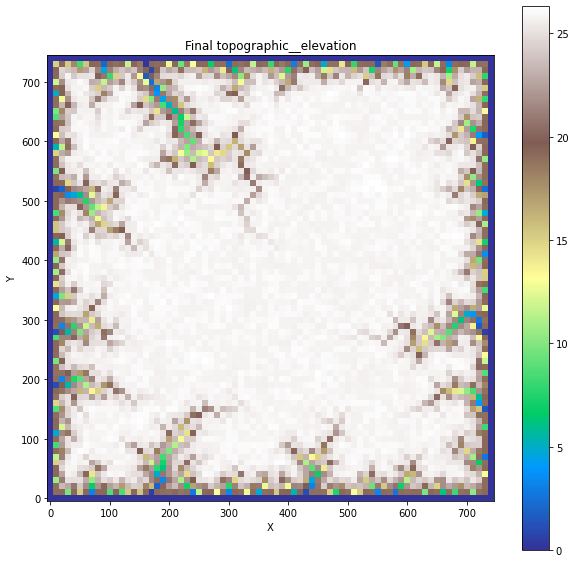

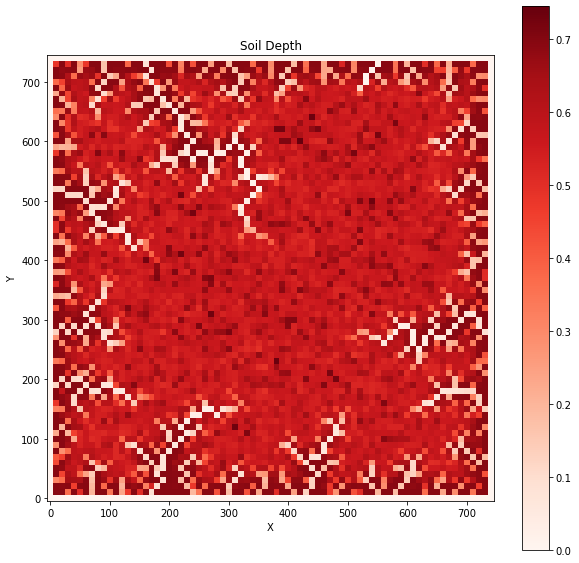

In [5]:
plt.figure(figsize=(10,10))
imshow_grid(mg, "topographic__elevation", cmap="terrain")
plt.title("Final topographic__elevation")
plt.figure(figsize=(10,10))
imshow_grid(mg, "soil__depth", cmap="Reds")
plt.title("Soil Depth")

Instantiate the lateral erosion component.

In [6]:
le = LateralEroderSolo(mg, K_br=0.00005, Kl_ratio = 3, K_sed=0.000075)
new_dt = 50

Run lateral erosion and space. Note the cell block below runs with a smaller time step (50 years) than the space code block (500 years).

In [9]:
mg.at_node['topographic__elevation'] = z_endspace
mg.at_node["soil__depth"] = s_endspace
mg.at_node["bedrock__elevation"] = br_endspace
le_cumu = mg.add_zeros("lateral_erosion__depth_cumu", at="node", clobber=True)

t1 = time.time()
for i in tqdm(range(100)):
    # Uplift
    br[mg.core_nodes] += 0.001 * new_dt
    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=new_dt)
    le.run_one_step_basic(dt=new_dt)

t_span1 = time.time() - t1
print('Total run time is %.f s' %t_span1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]

Total run time is 74 s


Note widened valleys in figures plotted below

In [ ]:
plt.figure(figsize=(10,10))
imshow_grid(mg, "topographic__elevation", cmap="terrain")
plt.title("Final topographic__elevation")
plt.figure(figsize=(10,10))
imshow_grid(mg, "lateral_erosion__depth_cumu", cmap="Greys_r", vmin=np.min(mg.at_node["lateral_erosion__depth_cumu"])*0.5)
plt.title("Cumulative Lateral Erosion")

In cell below, time step is large (500 years) same size as in space only cell.

In [ ]:
# z_ori = np.array(z)
mg.at_node['topographic__elevation'] = z_endspace
mg.at_node["soil__depth"] = s_endspace
mg.at_node["bedrock__elevation"] = br_endspace
le_cumu = mg.add_zeros("lateral_erosion__depth_cumu", at="node", clobber=True)

t1 = time.time()
for i in tqdm(range(100)):
    # Uplift
    br[mg.core_nodes] += 0.001 * space_dt
    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)
    le.run_one_step_basic(dt=space_dt)

t_span1 = time.time() - t1
print('Total run time is %.f s' %t_span1)

In [ ]:
plt.figure(figsize=(10,10))
imshow_grid(mg, "topographic__elevation", cmap="terrain")
plt.title("Final topographic__elevation")
plt.figure(figsize=(10,10))
imshow_grid(mg, "lateral_erosion__depth_cumu", cmap="Greys_r", vmin=np.min(mg.at_node["lateral_erosion__depth_cumu"])*0.5)
plt.title("Cumulative Lateral Erosion")

Now add landslides. Landslides needs the separate hill slope flow stuff below

In [ ]:
# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
fa_PF = PriorityFloodFlowRouter(
    mg,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

fa_PF.run_one_step()

# Plot output products
plotting(mg)

In [ ]:
ls = BedrockLandslider(
    mg, 
    angle_int_frict=.5,
    landslides_return_time=1e3,
    cohesion_eff = 1e3,)


In [ ]:
ls.run_one_step(dt=50)

In [ ]:
# Landslide Erosion 
cmap = copy.copy(mpl.cm.get_cmap("hot_r"))
imshow_grid(mg,np.sqrt(mg.at_node["landslide__erosion"]), colorbar_label = 'SQRT( Landslide erosion, m) ',cmap =cmap)
plt.show()

# Landslide Deposition 
cmap = copy.copy(mpl.cm.get_cmap("winter_r"))
imshow_grid(mg,np.sqrt(mg.at_node["landslide__deposition"]), colorbar_label = 'SQRT( Landslide deposition, m) ',cmap =cmap)
plt.show()